In [1]:
# Importing required libraries
try:
    import json, traceback, os, logging, re
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    import seaborn as sns
    from elasticsearch import Elasticsearch, helpers
    from ipywidgets import interact
    import ipywidgets as widgets
    from IPython.display import display
except ImportError as ie:
    print(ie)
else:
    # Setting up logging
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.DEBUG) # Debug and above level

    formatter = logging.Formatter('%(asctime)s:%(levelname)s:%(message)s')

    # File handler
    file_handler = logging.FileHandler('error.logs')
    file_handler.setLevel(logging.ERROR)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    # Print handler
    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.DEBUG)
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)

In [20]:
# Importing movie details from csv file
project_dir = os.path.abspath(os.path.dirname(__name__))
data_dir = os.path.join(project_dir, "IMDB")
try:
    movies = pd.read_csv(os.path.join(data_dir, "IMDB movies.csv"), low_memory=False)
except FileNotFoundError as fn:
    logger.error(f"No file named \'{os.path.basename(fn.filename)}\'"
          f"can be found at \'{data_dir}\'")

In [21]:
# Checking for empty values
movies.isna().sum()

imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                     64
language                   833
director                    87
writer                    1572
production_company        4455
actors                      69
description               2115
avg_vote                     0
votes                        0
budget                   62145
usa_gross_income         70529
worlwide_gross_income    54839
metascore                72550
reviews_from_users        7597
reviews_from_critics     11797
dtype: int64

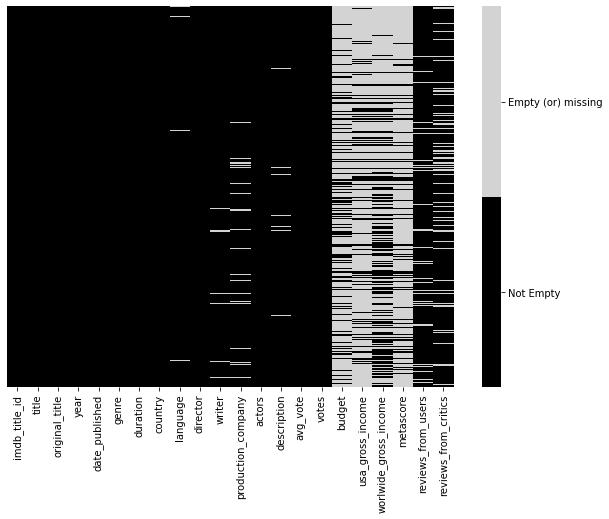

In [22]:
# Visualising Empty values
f, ax = plt.subplots(figsize=(10, 7))

colors = ["black", "lightgrey"] 
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

sns.heatmap(movies.isna(), yticklabels=False, cbar=True,cmap=cmap)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25,0.75])
colorbar.set_ticklabels(['Not Empty', 'Empty (or) missing'])

In [23]:
# Dropping empty values from Country and language columns (we only use these columns)
movies.dropna(subset=['language', 'country'], how='any', inplace=True)

In [24]:
# Stripping strings from year column and converting it to int
try:
    movies['year'] = movies['year'].apply(lambda year: re.sub(r'\D','',str(year))).astype(int)
    #movies['year'] = movies['year'].astype(int)
except Exception as e:
    print(e)

In [25]:
# Storing all unique genre in a list, with additional value, "Any"
genre = ['Any', *[genr for genr in movies['genre'].unique() if len(genr.split()) == 1]]
genre.sort()
logger.debug(genre)

2022-04-25 12:04:45,133:DEBUG:['Action', 'Adventure', 'Animation', 'Any', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


In [26]:
json_df = movies.to_dict('records')
json_df[0]

{'imdb_title_id': 'tt0000009',
 'title': 'Miss Jerry',
 'original_title': 'Miss Jerry',
 'year': 1894,
 'date_published': '1894-10-09',
 'genre': 'Romance',
 'duration': 45,
 'country': 'USA',
 'language': 'None',
 'director': 'Alexander Black',
 'writer': 'Alexander Black',
 'production_company': 'Alexander Black Photoplays',
 'actors': 'Blanche Bayliss, William Courtenay, Chauncey Depew',
 'description': 'The adventures of a female reporter in the 1890s.',
 'avg_vote': 5.9,
 'votes': 154,
 'budget': nan,
 'usa_gross_income': nan,
 'worlwide_gross_income': nan,
 'metascore': nan,
 'reviews_from_users': 1.0,
 'reviews_from_critics': 2.0}

## Elasticsearch

In [27]:
index = "movies_engine"
es = Elasticsearch("http://localhost:9200")
es.ping()

True

In [28]:
# Formating into ES required format
def es_format(data):
    for record in data:
        yield {
            "_index": index,
            "_id": record['imdb_title_id'],
            "_source": {
                "title": record['title'],
                "releaseYear": record['year'],
                "language": record['language'],
                "genre": record['genre'],
                "country": record['country'],
                "score": record['avg_vote']
            }
        }

In [29]:
# Defining settings and mappings for ES
setting = {
    "number_of_shards": 1,
    "number_of_replicas": 0,
    'analysis': {
        
        "filter":{
            "title_synonym": {
                "type": "synonym",
                "synonyms": [
                    "inception => dream"
                ]
            }
        },
        
        "tokenizer": {
            "my_tokenizer": {
                "type": "edge_ngram",
                "min_gram": 2,
                "max_gram": 8,
                "token_chars": ["letter", "digit"]
            }
        },
        
        'analyzer': {
            'title_tokenizer': {
                'type': 'custom',
                'tokenizer': 'my_tokenizer',
                "filter": [
                    "lowercase",
                    "title_synonym"
                ]
            },
            
        },
        
    }
}

mapping = {
    "properties": {
        "releaseYear": {
            "type": "date",
            "format": "yyyy"
        },
        "title": {
            "type": "text",
            "analyzer": "title_tokenizer"
        },
        "genre": {
            "type": "text",
            "analyzer": "standard"
        },
        "score": {
            "type": "byte"
        }
    }
}

#es.indices.delete(index=index, ignore=[400,404])
if not es.indices.exists(index=index):
    es.indices.create(index=index,settings=setting, mappings=mapping, ignore=400)
    helpers.bulk(es, es_format(json_df), ignore=[400,404])
else: # If index is present, then checking existing mappings
    print(json.dumps(es.indices.get_mapping(index=index), indent=2))

{
  "movies_engine": {
    "mappings": {
      "properties": {
        "country": {
          "type": "text",
          "fields": {
            "keyword": {
              "type": "keyword",
              "ignore_above": 256
            }
          }
        },
        "genre": {
          "type": "text",
          "analyzer": "standard"
        },
        "language": {
          "type": "text",
          "fields": {
            "keyword": {
              "type": "keyword",
              "ignore_above": 256
            }
          }
        },
        "releaseYear": {
          "type": "date",
          "format": "yyyy"
        },
        "score": {
          "type": "byte"
        },
        "title": {
          "type": "text",
          "analyzer": "title_tokenizer"
        }
      }
    }
  }
}


In [30]:
# Function to exicute search
def search(movie_name, bool_body):
    querry_body = {
        "bool": bool_body
    }
    
    suggestion_body = {
        "my_suggestion": {
            "text": movie_name,
            "term": {
                "field": "title"
            }
        }
    }
    
    return es.search(index='movies_engine', query=querry_body, suggest=suggestion_body,
                     size=10, ignore=[400])

In [34]:
# Printing result of search in desired format
def print_movies(data):
    print("{0:^40} | {1:^8} | {2:^8} | {3:^37} | {4:^30}".format("Title", "Year", "Rating", "Genre", "Language", "Rating"))
    print("-"*130)
    for obj in data['hits']['hits']:
        print("{title:<40} | {releaseYear:^8} | {score:^8} | {genre:^37} | {language:^30}".format(**obj['_source']))

In [35]:
def filtered_movies(genre, rating, movie_name):
    #Boolean querry body
    movie_filter = {
            "must": [
                {
                    "match": {
                        "title": {
                            "query": movie_name
                        }
                    }
                }
            ],
            "filter": [],
            "should": [
                {
                    "match_phrase": {
                        "title": {
                            "query": movie_name,
                            "slop": 2
                        }
                    }
                }
            ]
        }
    
    
    if len(movie_name) == 0:
        print("Search something to see results")
    else:
        
        if genre != 'Any':
            movie_filter['filter'].append({"match": {"genre": genre}})
        
        if rating != 0:
            movie_filter['filter'].append({"range": {"score": { "gte": rating }}})
            
        result = search(movie_name, movie_filter)
        print_movies(result)

In [33]:
# selected_genre = widgets.Dropdown(options=genre, value='Any', description='Genre')
# display(selected_genre)
interact(filtered_movies, 
         genre=genre,
         rating=widgets.IntSlider(min=0, max=10, value=0, step=1), 
         movie_name='',
        );

interactive(children=(Dropdown(description='genre', options=('Action', 'Adventure', 'Animation', 'Any', 'Biogr…